#Waymo Open Dataset Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



## Install waymo_open_dataset package

In [ ]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

In [ ]:
!pip3 install waymo-open-dataset-tf-2-11-0==1.5.1
!pip3 install Pillow==9.2.0

In [1]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

2023-04-13 20:56:00.943948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 20:56:01.076763: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 20:56:01.708778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/f

## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [2]:
# FILENAME = '/content/waymo-od/tutorial/frames'
FILENAME = '/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v1_4_2/validation/segment-1024360143612057520_3580_000_3600_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

2023-04-13 20:58:03.540018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 20:59:10.264392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/usr/local/cuda/lib64
2023-04-13 20:59:10.264421: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skip

In [3]:
(range_images, camera_projections,
 _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [4]:
print(frame.context)

name: "1024360143612057520_3580_000_3600_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2044.5083584358413
  intrinsic: 2044.5083584358413
  intrinsic: 949.5746451352071
  intrinsic: 633.2422462156501
  intrinsic: 0.040358363932006036
  intrinsic: -0.33001662226602974
  intrinsic: 0.0010402702690110032
  intrinsic: -0.0015669020781401406
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999943159291765
    transform: -0.0027625635198727494
    transform: 0.001932964597970193
    transform: 1.5386347086190375
    transform: 0.0027454768460688306
    transform: 0.9999576234529306
    transform: 0.008787130092066883
    transform: -0.024394341231793928
    transform: -0.0019571576906416434
    transform: -0.008781773235849106
    transform: 0.9999595241771579
    transform: 2.1150940771840068
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEF

## Visualize Camera Images and Camera Labels

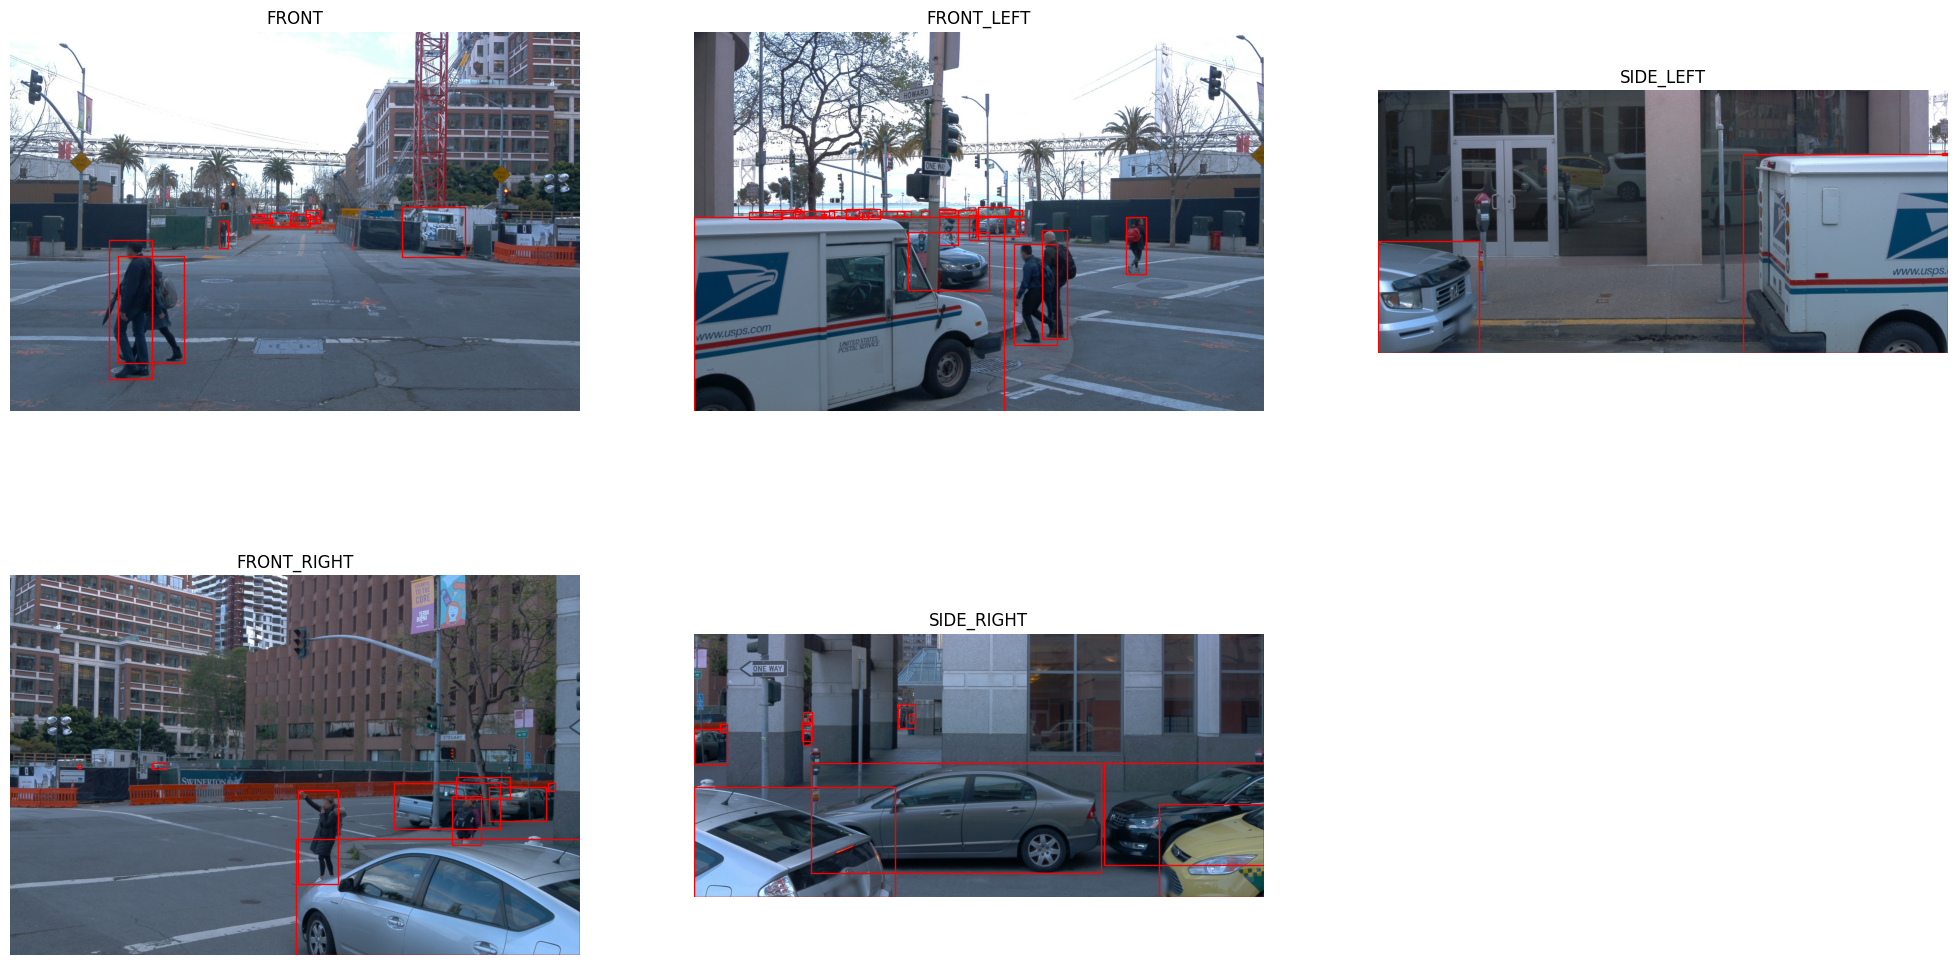

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

##Visualize Range Images

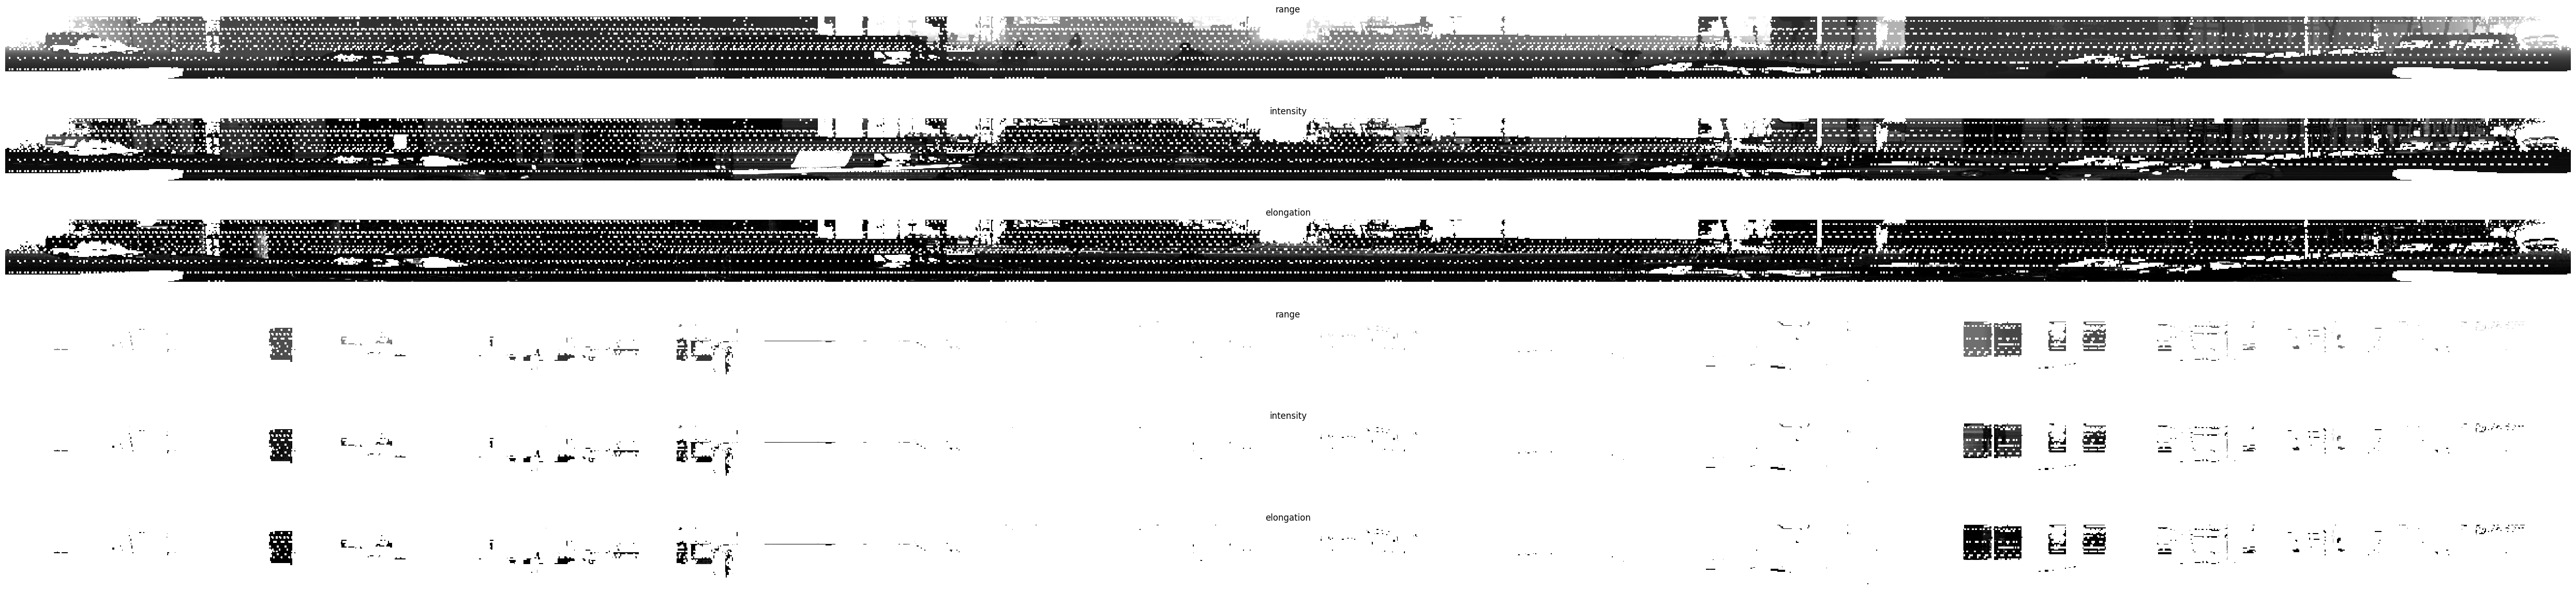

In [6]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [7]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [8]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(162179, 3)
(162179, 6)
[[-57.703125    9.125       5.0381775]
 [-57.734375    9.419922    5.0403748]]
(144878, 3)
(144878, 6)
(3657, 3)
(3657, 6)
(4522, 3)
(4522, 6)
(4330, 3)
(4330, 6)
(4792, 3)
(4792, 6)


Second return.

In [9]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(12279, 3)
(12279, 6)
[[-63.664062   11.951172    5.3311157]
 [-13.2734375  11.941406    3.028595 ]]
(12148, 3)
(12148, 6)
(14, 3)
(14, 6)
(24, 3)
(24, 6)
(37, 3)
(37, 6)
(56, 3)
(56, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

In [10]:
from IPython.display import Image, display
display(Image('/content/waymo-od/tutorial/3d_point_cloud.png'))

FileNotFoundError: No such file or directory: '/content/waymo-od/tutorial/3d_point_cloud.png'

FileNotFoundError: No such file or directory: '/content/waymo-od/tutorial/3d_point_cloud.png'

<IPython.core.display.Image object>

##Visualize Camera Projection

In [11]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [12]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

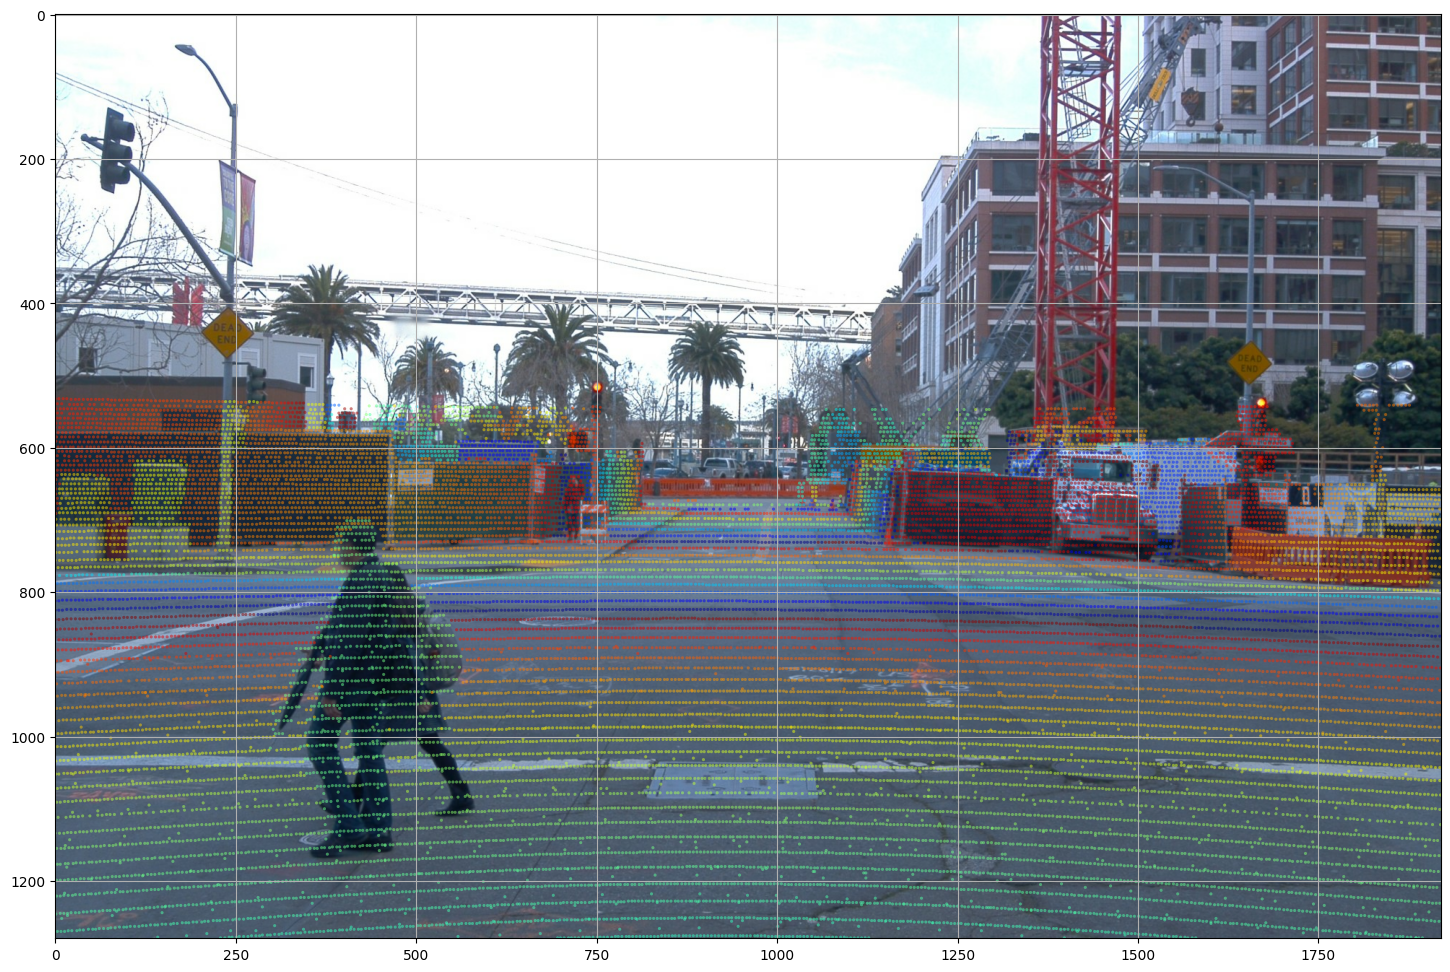

In [13]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

## Install from source code

The remaining part of this colab covers details of installing the repo form source code which provides a richer API.

### Install dependencies

In [14]:
!npm install -g @bazel/bazelisk

npm WARN checkPermissions Missing write access to /usr/local/lib/node_modules/@bazel/bazelisk
npm WARN checkPermissions Missing write access to /usr/local/lib/node_modules/@bazel
npm ERR! code EACCES
npm ERR! syscall access
npm ERR! path /usr/local/lib/node_modules/@bazel/bazelisk
npm ERR! errno -13
npm ERR! Error: EACCES: permission denied, access '/usr/local/lib/node_modules/@bazel/bazelisk'
npm ERR!  { [Error: EACCES: permission denied, access '/usr/local/lib/node_modules/@bazel/bazelisk']
npm ERR!   stack:
npm ERR!    'Error: EACCES: permission denied, access \'/usr/local/lib/node_modules/@bazel/bazelisk\'',
npm ERR!   errno: -13,
npm ERR!   code: 'EACCES',
npm ERR!   syscall: 'access',
npm ERR!   path: '/usr/local/lib/node_modules/@bazel/bazelisk' }
npm ERR! 
npm ERR! The operation was rejected by your operating system.
npm ERR! It is likely you do not have the permissions to access this file as the current user
npm ERR! 
npm ERR! If you believe this might be a permissions issue, 

###Build and test

NOTE: It can take 10-30 mins (sometimes more) depending on available compute resources.

Configure .bazelrc. This works with/without Tensorflow. This colab machine has Tensorflow installed.

In [ ]:
!pip3 install patchelf
!cd /content/waymo-od/src/ && bazelisk test //waymo_open_dataset/... --show_progress_rate_limit=10.0

### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [ ]:
!cd /content/waymo-od/src/ && bazel-bin/waymo_open_dataset/metrics/tools/compute_detection_metrics_main waymo_open_dataset/metrics/tools/fake_predictions.bin  waymo_open_dataset/metrics/tools/fake_ground_truths.bin

### Build local PIP package

In [ ]:
!cd /content/waymo-od/src/ && bazelisk build -c opt  //waymo_open_dataset/pip_pkg_scripts:wheel
!ls -R -l -h /content/waymo-od/src/bazel-bin/waymo_open_dataset/pip_pkg_scripts/waymo_open_dataset_tf_2.11.0*

You can install the locally compiled package or access any c++ binary compiled from this.